In [427]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
import numpy as np
from src.models.feature.GooLeNet import GoogLeNet
from src.models.feature.ResNet import ResNet18

In [428]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')
    
#class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

In [429]:
model = ResNet18(classes=len(class_name)).to(device)

model.load_state_dict(torch.load('./pretrain/resnet18_stl10_gvap_model_1.pth'))

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (relu2): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1):

In [430]:
feature_blobs = []

def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())

print(model._modules)

model._modules.get('Block4').register_forward_hook(hook_feature)

params = list(model.parameters())

class_weights = np.squeeze(params[-2].cpu().data.numpy())

OrderedDict([('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))), ('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('relu1', ReLU()), ('max_pool1', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('Block1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
    (relu2): ReLU()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2

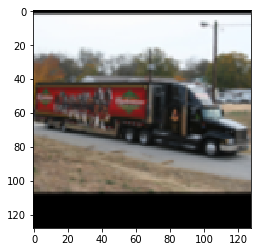

In [431]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = './test_img/stl10/test1.png'

img = Image.open(img_path)

plt.imshow(img)

In [432]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor()])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 128,128)

output = model(tensor_img)

In [433]:
from torch.nn import functional as F

h_x = F.softmax(output, dim=1).data.squeeze()

In [434]:
print(h_x.sort(0, True))

pred = h_x.argmax(0).item()
print(pred)
print(class_name[pred])

torch.return_types.sort(
values=tensor([1.0000e+00, 5.4920e-08, 2.1334e-11, 9.0740e-12, 4.6348e-12, 1.6048e-12,
        6.5453e-13, 6.1752e-13, 4.2914e-14, 8.6676e-16]),
indices=tensor([9, 2, 7, 3, 0, 6, 8, 1, 5, 4]))
9
truck


In [435]:
feature_blobs[0][0].shape

(512, 4, 4)

In [436]:
class_weights.shape

(10, 512)

In [437]:
def gen_feature_map(feature_):
    length = len(feature_)
    
    size = np.sqrt(1024)
    
    r, c = int(size), int(size)

    fig, axs = plt.subplots(r, c, figsize=(10,10))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(feature_[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("feature_%s.png" % class_name[pred])
    plt.show()
    
def min_max_scaling(cam):
    cam = (cam - np.min(cam)) / np.max(cam) - np.min(cam)
    return cam

def standard_scaling(cam):
    cam = (cam - np.mean(cam)) / np.std(cam)
    return cam

def scaling(cam):
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    #cam = 
    
    return cam

In [438]:
final_conv = feature_blobs[0][0]

cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i, w in enumerate(class_weights[pred]):
    cam += w*final_conv[i,:,:]

In [439]:
feature_ = []

for i, w in enumerate(class_weights[pred]):
    feature_.append(w*final_conv[i,:,:])
    
#gen_feature_map(feature_)

In [440]:
cnt = 0
for f in feature_:
    if np.sum(np.abs(f)) == 0:
        cnt+=1
print(cnt)

78


In [441]:
scaled_cam = scaling(cam)
scaled_cam

array([[0.        , 0.1229759 , 0.18999472, 0.0895564 ],
       [0.2562275 , 0.5266143 , 0.54704297, 0.35693565],
       [0.31181318, 0.716953  , 1.        , 0.7449979 ],
       [0.18430954, 0.43178833, 0.49581107, 0.42801818]], dtype=float32)

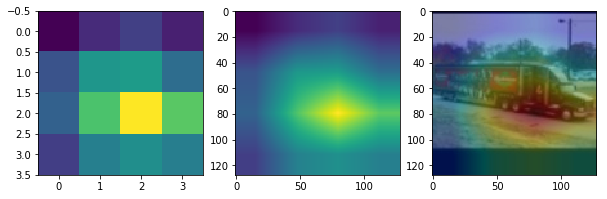

In [442]:
import cv2

fig, axs = plt.subplots(1, 3, figsize=(10,10))

axs[0].imshow(scaled_cam)

resized_cam = cv2.resize(scaled_cam, (128, 128))

axs[1].imshow(resized_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * resized_cam), cv2.COLORMAP_JET)

img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))
heatimg = heatmap*0.3 + img*0.5
cv2.imwrite('./cam.jpg', heatimg)

cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

axs[2].imshow(cam_img)